In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np

In [88]:
def get_wiki_table(wikiurl, table_id = 0):
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(wikiurl)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table', {"class":"wikitable"})
    table = tables[table_id]
    df = pd.read_html(str(table))
    df=pd.DataFrame(df[0])
    df=flatten_headers(df)
    return df

In [89]:
def flatten_headers(df):
    df.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in df.columns]
    return df

In [90]:

income_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_income_equality'
wealth_url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_by_wealth_inequality'

income_df = get_wiki_table(income_url)
wealth_df = get_wiki_table(wealth_url)

In [92]:
income_df_filtered = income_df[["Country_Country", "World Bank Gini[5][6]_%"]]

In [93]:
wealth_df_filtered = wealth_df[["Country_Country", "Wealth Gini_2021"]]

In [94]:
income_df_filtered['Country_Country'] = income_df_filtered['Country_Country'].str.replace(r'\s*\*$', '', regex=True)
wealth_df_filtered['Country_Country'] = wealth_df_filtered['Country_Country'].str.replace(r'\s*\*$', '', regex=True)

/var/folders/sk/yhg8rcg53cv1hcz6qlyn9wcm0000gn/T/ipykernel_62168/2720213175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df_filtered['Country_Country'] = income_df_filtered['Country_Country'].str.replace(r'\s*\*$', '', regex=True)
/var/folders/sk/yhg8rcg53cv1hcz6qlyn9wcm0000gn/T/ipykernel_62168/2720213175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wealth_df_filtered['Country_Country'] = wealth_df_filtered['Country_Country'].str.replace(r'\s*\*$', '', regex=True)


In [95]:
merged_df = pd.merge(income_df_filtered, wealth_df_filtered, on="Country_Country", how="outer")

In [96]:
merged_df.rename(columns={"World Bank Gini[5][6]_%": "Income Gini", "Wealth Gini_2021": "Wealth Gini"}, inplace=True)

In [97]:
merged_df['Wealth Gini'] = merged_df['Wealth Gini'].replace('—', np.nan).astype('float64')

In [98]:
merged_df["Income Gini"] = merged_df["Income Gini"] / 100

In [99]:
merged_df["Lobby index"] = merged_df["Wealth Gini"] / merged_df["Income Gini"]
merged_df.sort_values(by="Lobby index", ascending=False)

,Country_Country,Income Gini,Wealth Gini,Lobby index
159,United Arab Emirates,0.260,0.885,3.403846
158,Ukraine,0.256,0.834,3.257812
1,Algeria,0.276,0.848,3.072464
37,Czech Republic,0.262,0.776,2.961832
144,Sweden,0.298,0.881,2.956376
...,...,...,...,...
185,Samoa,NaN,0.777,NaN
186,Solomon Islands,NaN,0.814,NaN
187,Saint Vincent and the Grenadines,NaN,0.813,NaN
188,Tonga,NaN,0.777,NaN


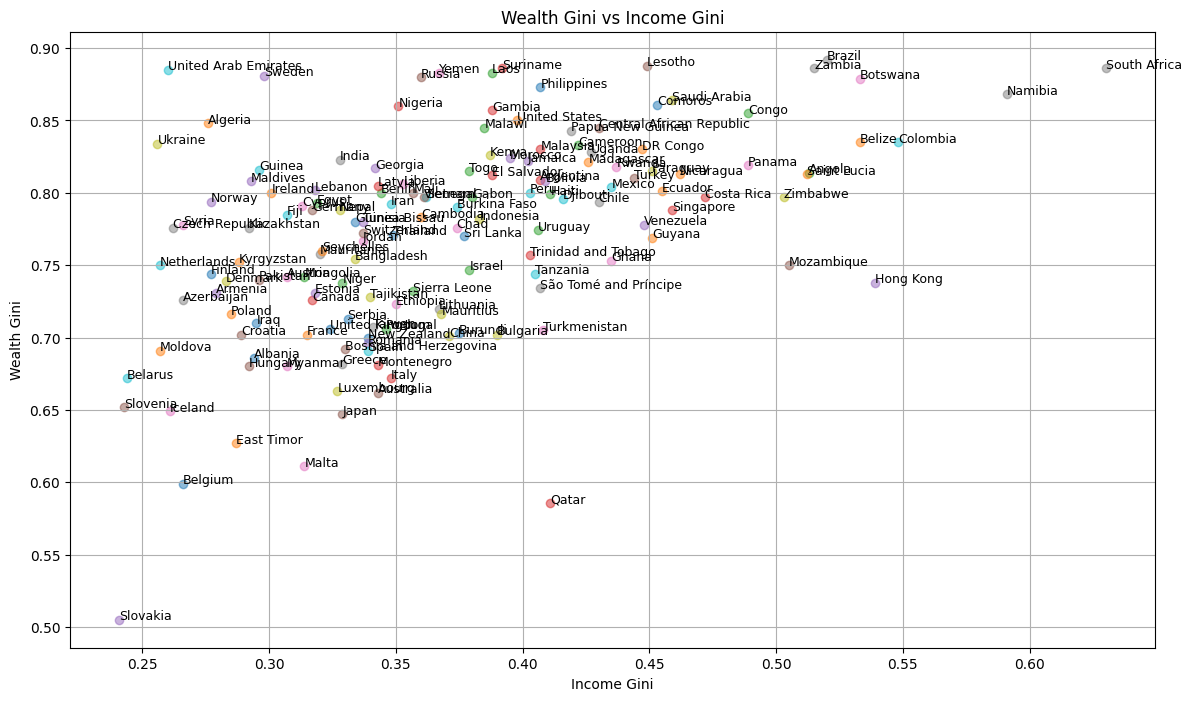

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))  # Increased figure size for better visibility
for i, txt in enumerate(merged_df['Country_Country']):
    plt.scatter(merged_df['Income Gini'][i], merged_df['Wealth Gini'][i], alpha=0.5)
    plt.annotate(txt, (merged_df['Income Gini'][i], merged_df['Wealth Gini'][i]), fontsize=9)  # Added fontsize for better readability
plt.title('Wealth Gini vs Income Gini')
plt.xlabel('Income Gini')
plt.ylabel('Wealth Gini')
plt.grid(True)
# plt.xlim(left=0)  # Set x-axis to start from 0
# plt.ylim(bottom=0)  # Set y-axis to start from 0
plt.show()


In [80]:
merged_df.sort_values(by="Lobby index", ascending=False).to_csv("sorted_lobby_index.csv")

# Income after taxes

In [103]:
income_after_taxes_df = get_wiki_table(income_url, table_id=3)

In [107]:
merged_data = pd.merge(wealth_df_filtered, income_after_taxes_df, left_on='Country_Country', right_on='Country', how='inner')

In [109]:
merged_data.drop(columns=['Country_Country'], inplace=True)
merged_data.rename(columns={'Wealth Gini_2021': 'Wealth Gini', 'Gini': 'Income Gini'}, inplace=True)

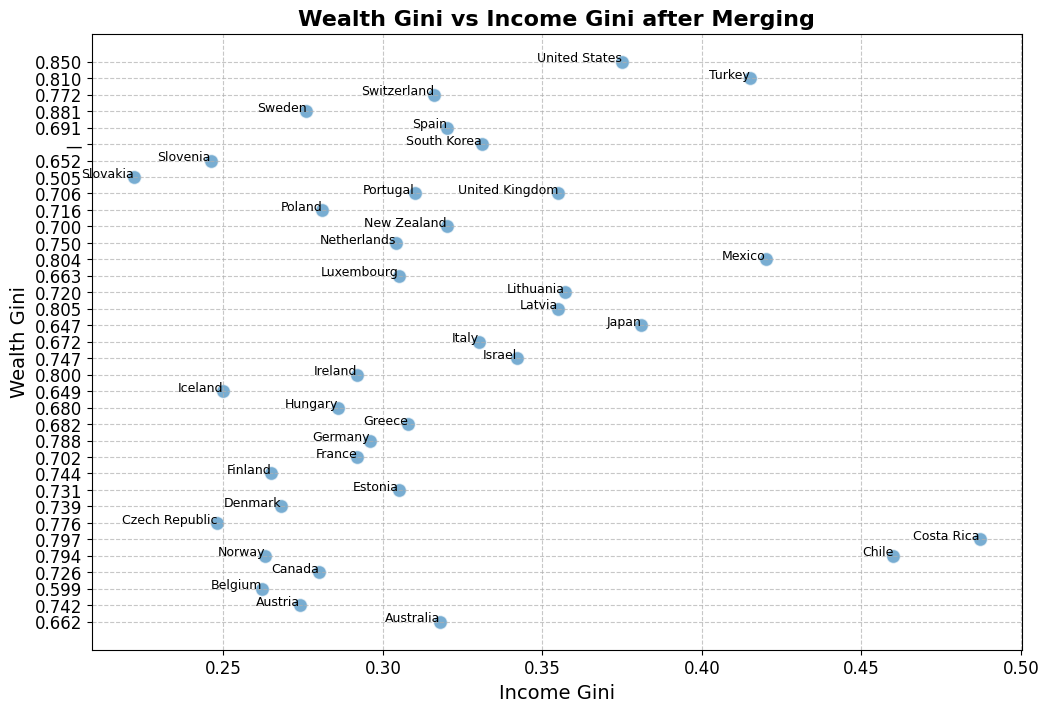

In [118]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(merged_data['Income Gini'], merged_data['Wealth Gini'], alpha=0.6,  edgecolors='w', s=100)
for i, txt in enumerate(merged_data['Country']):
    plt.annotate(txt, (merged_data['Income Gini'][i], merged_data['Wealth Gini'][i]), fontsize=9, ha='right')
plt.title('Wealth Gini vs Income Gini after Merging', fontsize=16, fontweight='bold')
plt.xlabel('Income Gini', fontsize=14)
plt.ylabel('Wealth Gini', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
# Чем больше Gini, тем больше неравенство
# Если неравенство капитала больше чем неравенство доходов, то есть лобирование
# Мы можем посчитать насколько неравенство капитала больше чем неравенство доходов, делим Wealth Gini на Income Gini